In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

In [2]:
def calculate_accuracies(data, thresholds):
    metrics = []
    for threshold in thresholds:
        correct_predictions_jaccard = sum(1 for item in data if item["similarity_score_jaccard"] >= threshold)
        correct_predictions_cosine = sum(1 for item in data if item["similarity_score_cosine"] >= threshold)
        total_questions = len(data)
        metrics.append({
            'Threshold': threshold,
            'Jaccard Accuracy': correct_predictions_jaccard / total_questions,
            'Cosine Accuracy': correct_predictions_cosine / total_questions,
            'Total Correct Jaccard': correct_predictions_jaccard,
            'Total Correct Cosine': correct_predictions_cosine
        })
    return pd.DataFrame(metrics)

In [3]:
with open('predictions.json', 'r') as file:
    data_with_context = json.load(file)['data']
with open('predictions_gpt.json', 'r') as file:
    data_without_context = json.load(file)['data']

thresholds = np.arange(0.0, 1.0, 0.001)

df_metrics_with_context = calculate_accuracies(data_with_context, thresholds)
df_metrics_without_context = calculate_accuracies(data_without_context, thresholds)

median_jaccard_with_context = df_metrics_with_context['Jaccard Accuracy'].median()
median_jaccard_without_context = df_metrics_without_context['Jaccard Accuracy'].median()
median_cosine_with_context = df_metrics_with_context['Cosine Accuracy'].median()
median_cosine_without_context = df_metrics_without_context['Cosine Accuracy'].median()

In [4]:
def find_intersection(func1, func2, x_range):
    x = np.linspace(x_range[0], x_range[1], num=1000)
    f1 = interp1d(x, func1(x), kind='linear')
    f2 = interp1d(x, func2(x), kind='linear')
    diff = f1(x) - f2(x)
    idx = np.argwhere(np.diff(np.sign(diff))).flatten()
    return x[idx], f1(x[idx])

In [5]:
x_range = (thresholds[0], thresholds[-1])

In [6]:
intersection_jaccard, accuracy_jaccard = find_intersection(
    lambda x: np.interp(x, df_metrics_with_context['Threshold'], df_metrics_with_context['Jaccard Accuracy']),
    lambda x: np.interp(x, df_metrics_without_context['Threshold'], df_metrics_without_context['Jaccard Accuracy']),
    (thresholds[0], thresholds[-1])
)
intersection_cosine, accuracy_cosine = find_intersection(
    lambda x: np.interp(x, df_metrics_with_context['Threshold'], df_metrics_with_context['Cosine Accuracy']),
    lambda x: np.interp(x, df_metrics_without_context['Threshold'], df_metrics_without_context['Cosine Accuracy']),
    (thresholds[0], thresholds[-1])
)

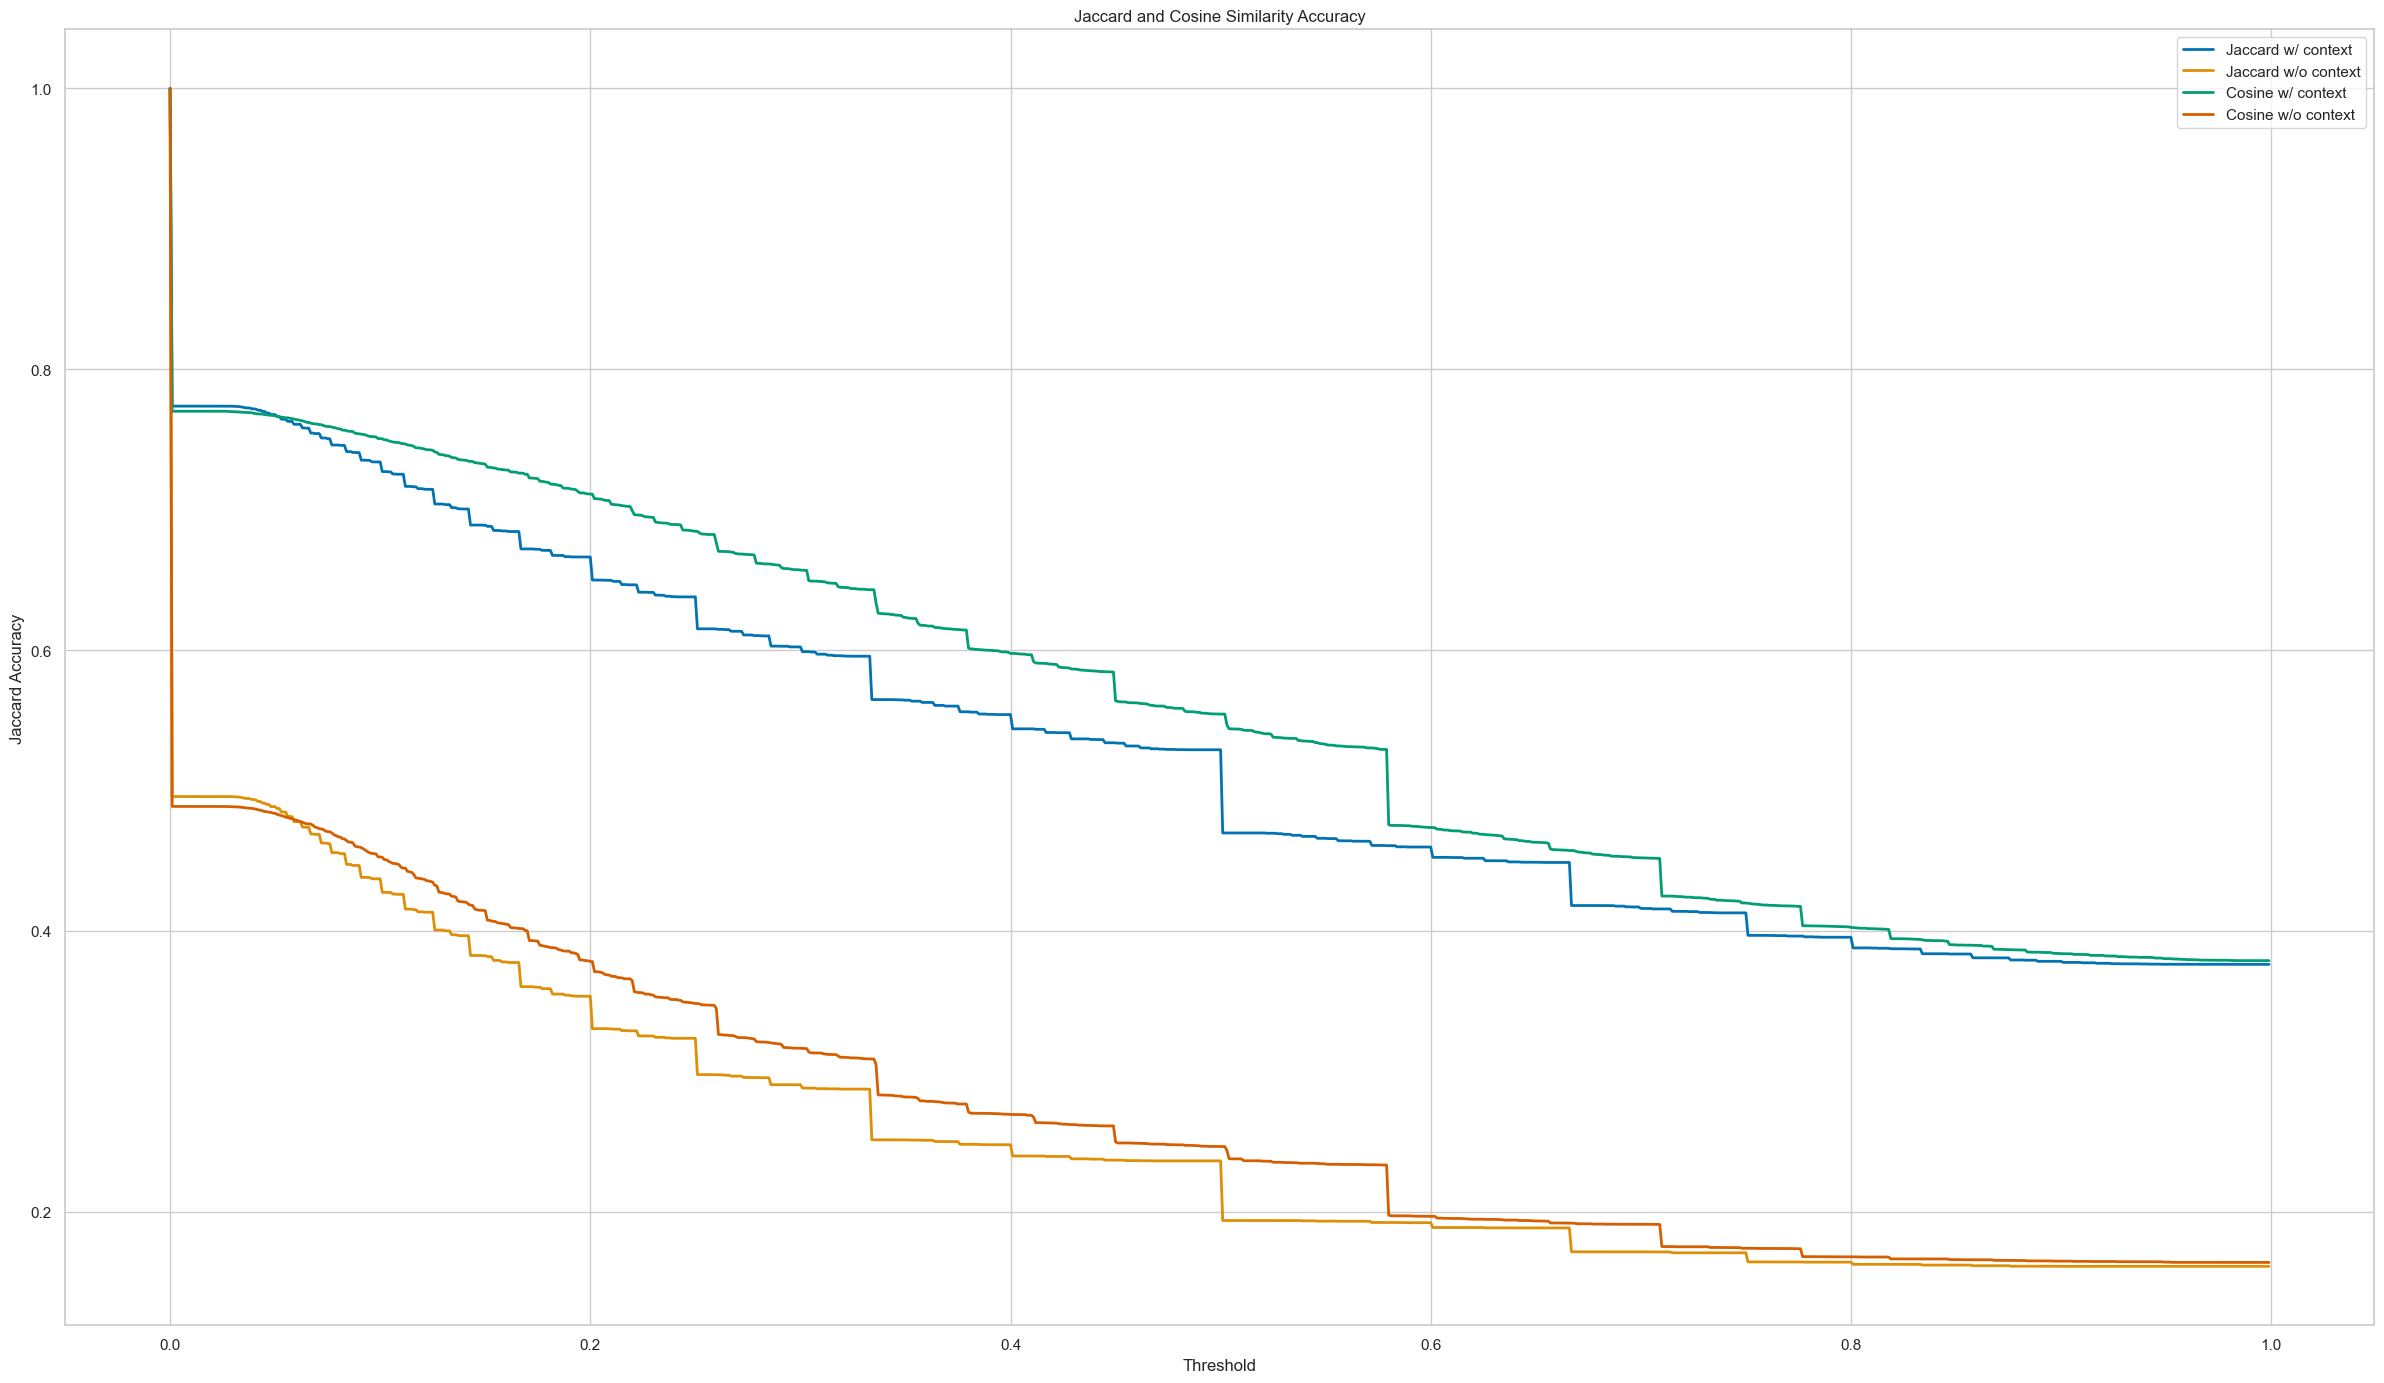

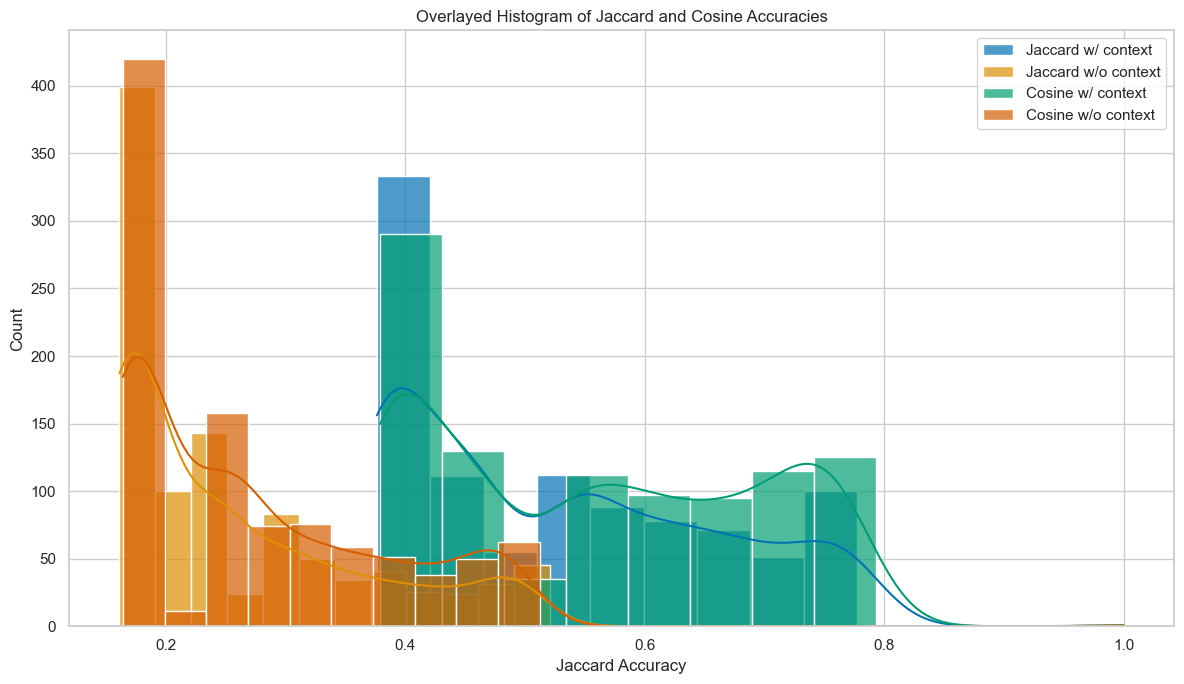

In [7]:
# Visualization setup
sns.set_theme(style="whitegrid")
palette = sns.color_palette("colorblind", as_cmap=False)
colors = [palette[i] for i in range(len(palette))]

# Line plot for accuracies
fig, ax = plt.subplots(figsize=(24, 14))
sns.lineplot(x='Threshold', y='Jaccard Accuracy', data=df_metrics_with_context, label='Jaccard w/ context', color=colors[0], lw=2, ax=ax)
sns.lineplot(x='Threshold', y='Jaccard Accuracy', data=df_metrics_without_context, label='Jaccard w/o context', color=colors[1], lw=2, ax=ax)
sns.lineplot(x='Threshold', y='Cosine Accuracy', data=df_metrics_with_context, label='Cosine w/ context', color=colors[2], lw=2, ax=ax)
sns.lineplot(x='Threshold', y='Cosine Accuracy', data=df_metrics_without_context, label='Cosine w/o context', color=colors[3], lw=2, ax=ax)
ax.set_title('Jaccard and Cosine Similarity Accuracy')
ax.legend()
plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=300)
plt.show()

# Histogram for accuracy distributions overlayed
fig, ax = plt.subplots(figsize=(12, 7))

# Histogram for Jaccard Accuracy
sns.histplot(df_metrics_with_context, x='Jaccard Accuracy', color=palette[0], label='Jaccard w/ context', kde=True, alpha=0.7, ax=ax)
sns.histplot(df_metrics_without_context, x='Jaccard Accuracy', color=palette[1], label='Jaccard w/o context', kde=True, alpha=0.7, ax=ax)

# Histogram for Cosine Accuracy on the same plot
sns.histplot(df_metrics_with_context, x='Cosine Accuracy', color=palette[2], label='Cosine w/ context', kde=True, alpha=0.7, ax=ax)
sns.histplot(df_metrics_without_context, x='Cosine Accuracy', color=palette[3], label='Cosine w/o context', kde=True, alpha=0.7, ax=ax)

# Title and legend
ax.set_title('Overlayed Histogram of Jaccard and Cosine Accuracies')
ax.legend()

plt.tight_layout()
plt.savefig('overlayed_accuracy_histograms.png', dpi=300)
plt.show()